#### Co-authored by Rushi Chavda(20D100007), Pragyesh Gupta(200020094), Nidhi Chaudhary(200040088) , Ashish (22M1587) and Rathore(213174001) as a result of our ME781 Data Mining final project.

Based on Data set from UCI's Machine Learning Repository https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset


The first and foremost step is to install and import the necessary libraires and this is done in the first step

In [ ]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score, train_test_split, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import xgboost as xgb
from xgboost import XGBClassifier

## Reading Data

Then, we proceed with reading the required data.
The dataset link is used to download the onlinne_shoppers_intention.csv file and that is read below

In [ ]:
# Reading shopping data
X_train = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00468/online_shoppers_intention.csv")
df = X_train.copy()
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


## Producing dummy variables for categorical data and cleaning data

The categorical data of 'VisitorType' is represented as numerical data via dummy variables. Dummy variables encode either one of the states as 0 and other value of the categorical feature variable as 1. Further, unnecessary variables of 'Revenue' and 'Returning_Visitor' and also the data is cleaned 

In [ ]:
dummiesdf = pd.get_dummies(df['VisitorType'])
df.drop('VisitorType', inplace = True, axis = 1)
df['New_Visitor'] = dummiesdf['New_Visitor']
df['Other'] = dummiesdf['Other']
df['Returning_Visitor'] = dummiesdf['Returning_Visitor']

In [ ]:
dfmonth = pd.get_dummies(df['Month']) 
df.drop('Month', inplace = True, axis = 1)
dfwithdummies = pd.concat([df, dfmonth], axis = 1, sort = False)

In [ ]:
dfwithdummies['Class'] = df['Revenue'].astype(int)
dfwithdummies.drop('Revenue', axis = 1, inplace = True)
dfwithdummies['Weekend'] = df['Weekend'].astype(int)
dfwithdummies.drop('Returning_Visitor', axis = 1, inplace = True)
dfcleaned = dfwithdummies.copy()

In [ ]:
X = dfcleaned.drop('Class', axis = 1)
Y = dfcleaned['Class'].copy()

In [ ]:
X.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,Aug,Dec,Feb,Jul,June,Mar,May,Nov,Oct,Sep
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0


In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  OperatingSystems         12330 non-null  int64  
 11  Browser                  12330 non-null  int64  
 12  Region                   12330 non-null  int64  
 13  TrafficType              12330 non-null  int64  
 14  Weekend               

## Checking for Collinearity 

Checking for collinearity between different features. It is done in order to find a relation between features and if there is a strong relationship between 2 features, i.e., if 2 features are collinear, then one of the two could be skipped while processing and analyzing data. This step, thus, helps to reduce the dimensions of the dataset, if any.

In [ ]:
cor = X.corr()

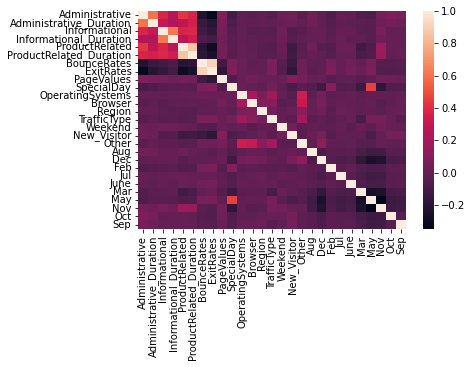

In [ ]:
sns.heatmap(cor, xticklabels=cor.columns,yticklabels=cor.columns)

In [ ]:
#dfcleaned[dfcleaned['New_Visitor'] == 1]['Administrative'].value_counts()

In [ ]:

def AvgMinutes(Count, Duration):
    if Duration == 0:
        output = 0
    elif Duration != 0:
        output = float(Duration)/float(Count)
    return output
    
Columns = [['Administrative', 'Administrative_Duration'], ['Informational', 'Informational_Duration'], ['ProductRelated', 'ProductRelated_Duration']]
    
    
X['AvgAdministrative'] = X.apply(lambda x: AvgMinutes(Count = x['Administrative'], Duration = x['Administrative_Duration']), axis = 1)
X['AvgInformational'] = X.apply(lambda x: AvgMinutes(Count = x['Informational'], Duration = x['Informational_Duration']), axis = 1)
X['AvgProductRelated'] = X.apply(lambda x: AvgMinutes(Count = x['ProductRelated'], Duration = x['ProductRelated_Duration']), axis = 1)
X.drop(['Administrative', 'Administrative_Duration','Informational', 'Informational_Duration','ProductRelated', 'ProductRelated_Duration'], axis = 1, inplace = True)

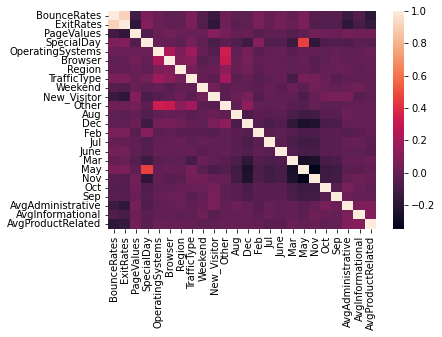

In [ ]:
cor = X.corr()
sns.heatmap(cor, xticklabels=cor.columns,yticklabels=cor.columns)

## Quick overview of features

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)


<Figure size 432x288 with 0 Axes>

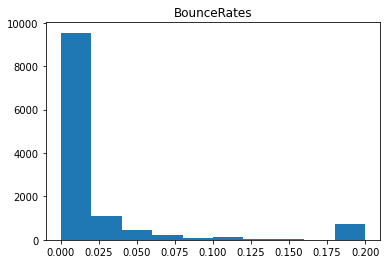

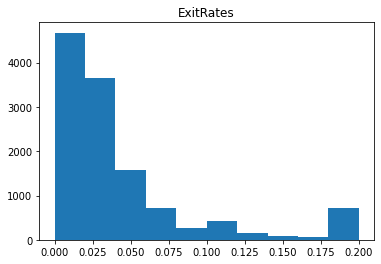

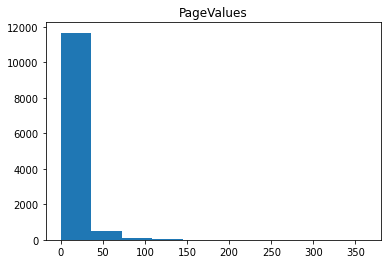

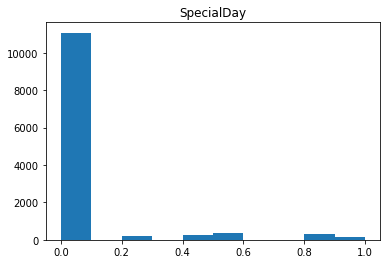

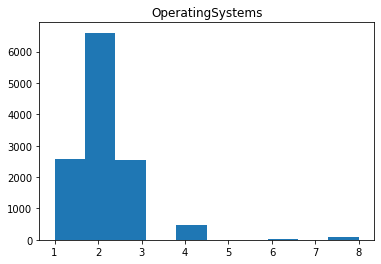

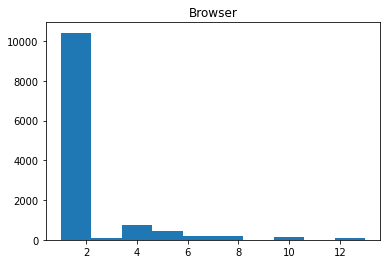

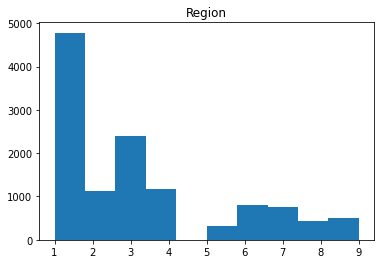

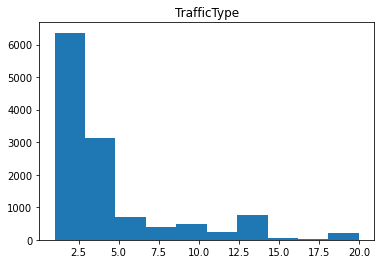

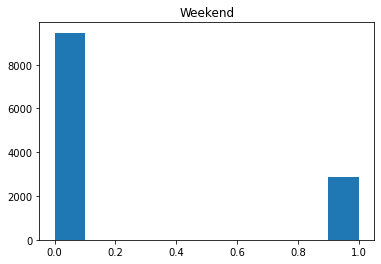

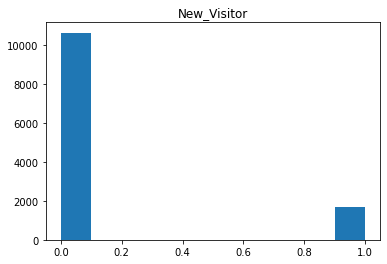

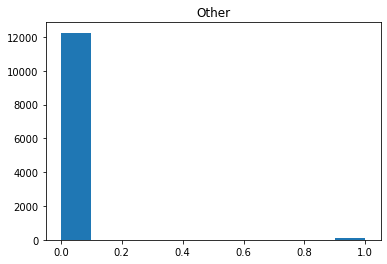

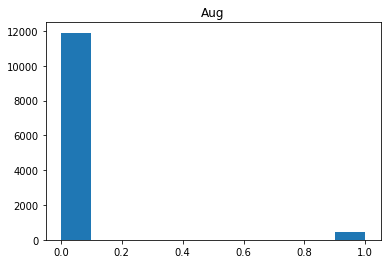

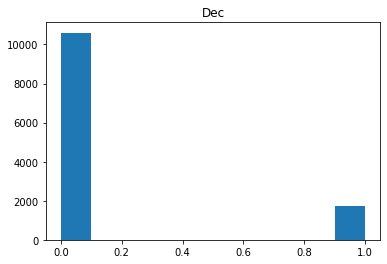

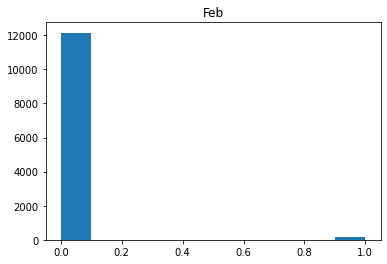

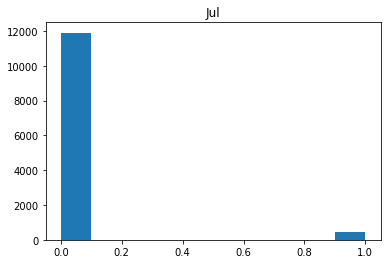

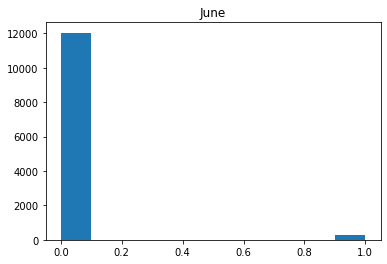

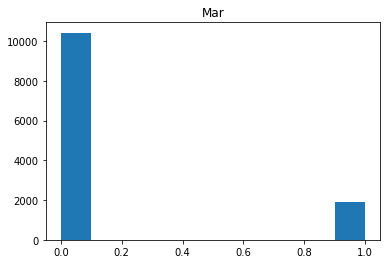

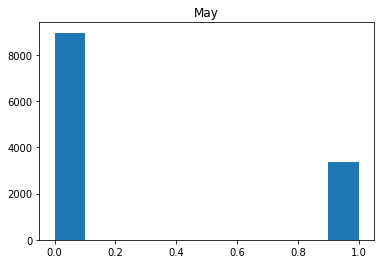

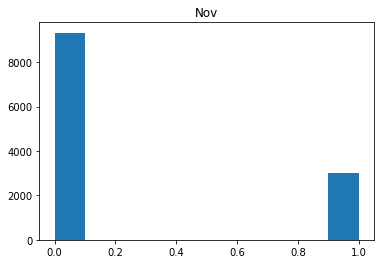

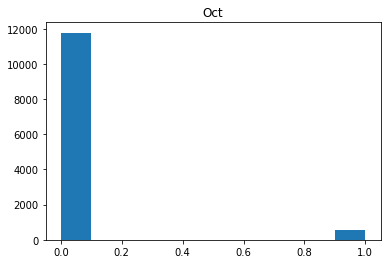

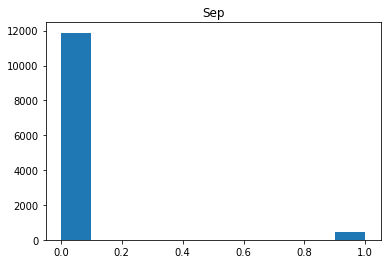

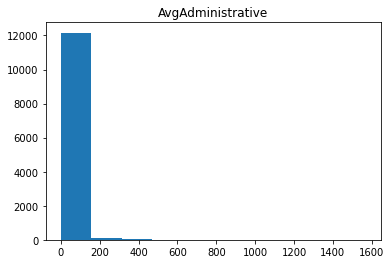

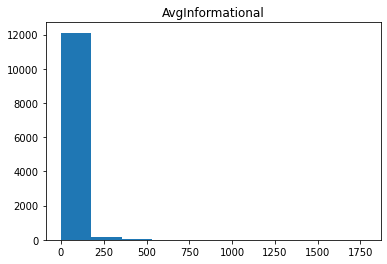

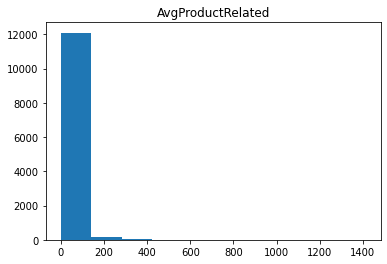

In [ ]:
# Histogram of all features
for idx,column in enumerate(X.columns): 
    plt.figure(idx)
    X.hist(column=column,grid=False)

In [ ]:
# Checking for NA values
for i in X.columns:
    print('Feature:',i)
    print('# of N/A:',X[i].isna().sum())

Feature: BounceRates
# of N/A: 0
Feature: ExitRates
# of N/A: 0
Feature: PageValues
# of N/A: 0
Feature: SpecialDay
# of N/A: 0
Feature: OperatingSystems
# of N/A: 0
Feature: Browser
# of N/A: 0
Feature: Region
# of N/A: 0
Feature: TrafficType
# of N/A: 0
Feature: Weekend
# of N/A: 0
Feature: New_Visitor
# of N/A: 0
Feature: Other
# of N/A: 0
Feature: Aug
# of N/A: 0
Feature: Dec
# of N/A: 0
Feature: Feb
# of N/A: 0
Feature: Jul
# of N/A: 0
Feature: June
# of N/A: 0
Feature: Mar
# of N/A: 0
Feature: May
# of N/A: 0
Feature: Nov
# of N/A: 0
Feature: Oct
# of N/A: 0
Feature: Sep
# of N/A: 0
Feature: AvgAdministrative
# of N/A: 0
Feature: AvgInformational
# of N/A: 0
Feature: AvgProductRelated
# of N/A: 0


In [ ]:
for i in X_train.columns:
    print('####################')
    print('COLUMN TITLE:',i)
    print('# UNIQUE VALUES:',len(X_train[i].unique()))
    print('UNIQUE VALUES:',X_train[i].unique())
    print('####################')
    print()

####################
COLUMN TITLE: Administrative
# UNIQUE VALUES: 27
UNIQUE VALUES: [ 0  1  2  4 12  3 10  6  5  9  8 16 13 11  7 18 14 17 19 15 24 22 21 20
 23 27 26]
####################

####################
COLUMN TITLE: Administrative_Duration
# UNIQUE VALUES: 3335
UNIQUE VALUES: [  0.         53.         64.6       ... 167.9107143 305.125
 150.3571429]
####################

####################
COLUMN TITLE: Informational
# UNIQUE VALUES: 17
UNIQUE VALUES: [ 0  1  2  4 16  5  3 14  6 12  7  9 10  8 11 24 13]
####################

####################
COLUMN TITLE: Informational_Duration
# UNIQUE VALUES: 1258
UNIQUE VALUES: [  0.   120.    16.   ... 547.75 368.25 211.25]
####################

####################
COLUMN TITLE: ProductRelated
# UNIQUE VALUES: 311
UNIQUE VALUES: [  1   2  10  19   0   3  16   7   6  23  13  20   8   5  32   4  45  14
  52   9  46  15  22  11  12  36  42  27  90  18  38  17 128  25  30  21
  51  26  28  31  24  50  96  49  68  98  67  55  35  37  29

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)


<Figure size 432x288 with 0 Axes>

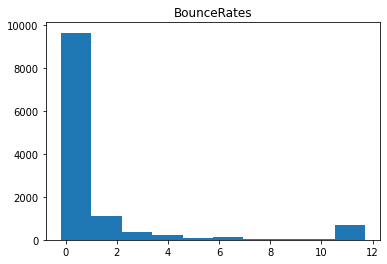

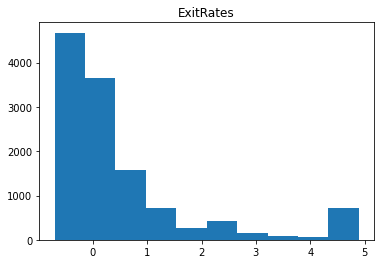

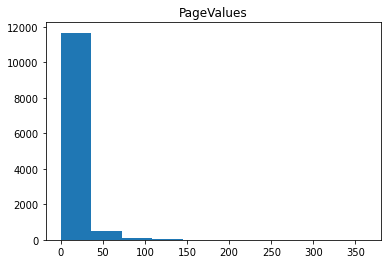

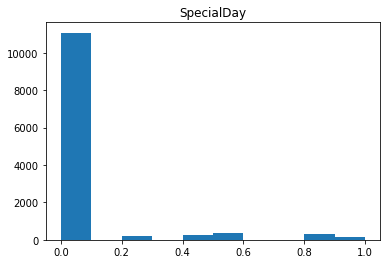

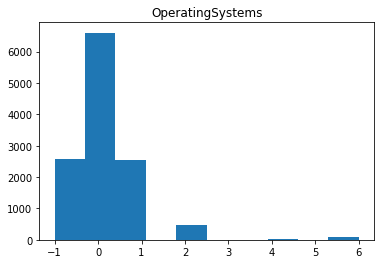

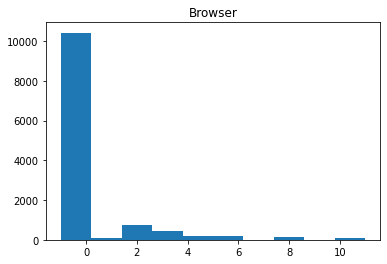

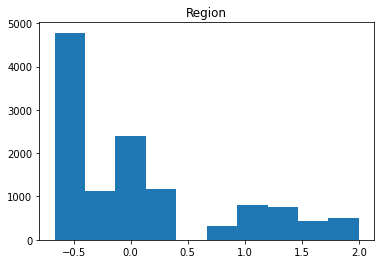

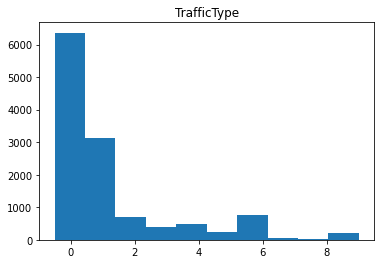

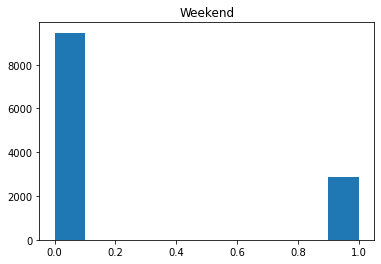

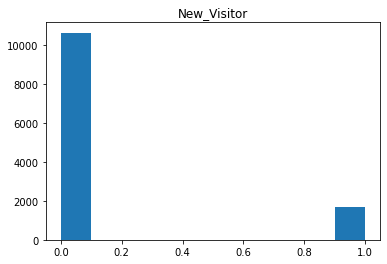

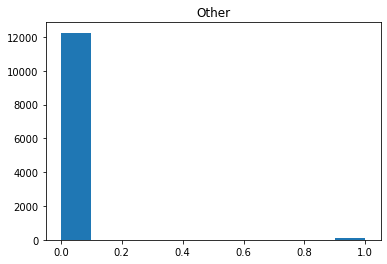

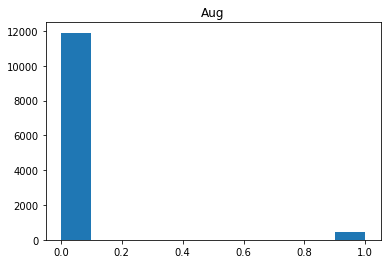

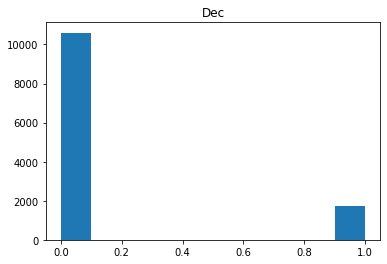

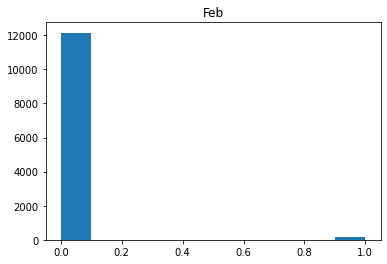

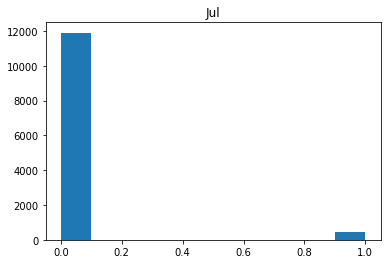

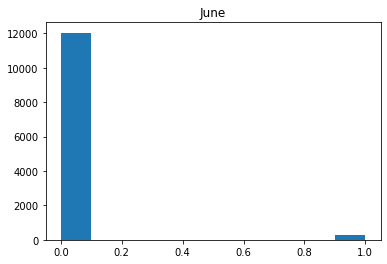

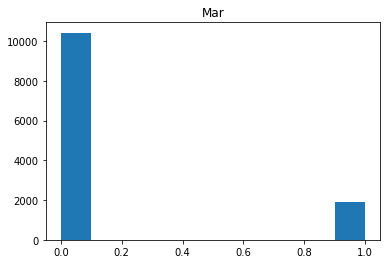

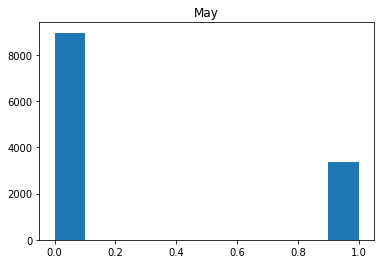

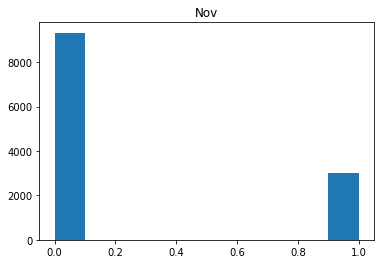

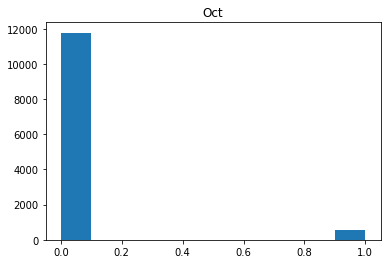

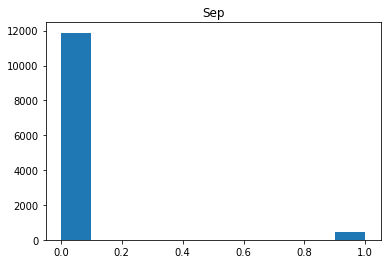

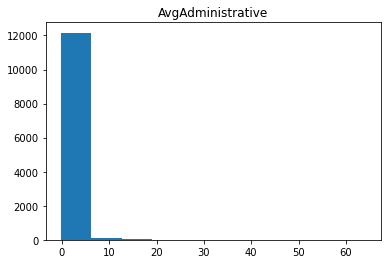

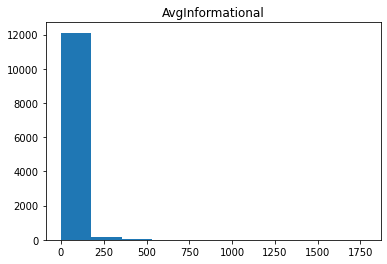

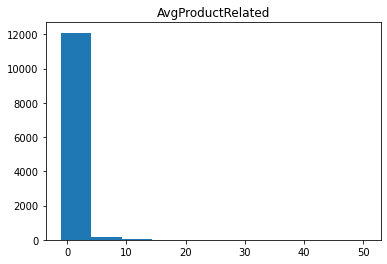

In [ ]:
# Scaling to normalize data
X_copy = X.copy()
rc = RobustScaler()
X_rc=rc.fit_transform(X_copy)
X_rc=pd.DataFrame(X_rc,columns=X.columns)

for idx,column in enumerate(X_rc.columns):
    plt.figure(idx)
    X_rc.hist(column=column,grid=False)

## Linear Model with All Features

We will first fit a linear model to see if that would result into something significant. We will be using Stochastic Gradient Descent to find the optimum for this linear model

In [ ]:
from sklearn import linear_model
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(X_rc,Y,test_size=.2)

In [ ]:
# Linear model
model = linear_model.SGDClassifier()
model.fit(X_train, y_train)

SGDClassifier()

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.8795620437956204

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_pred)

0.7660872697797991

## Random Forest with all Features

Then, we turn to our Random Forest Classifier. This Classifier creates a set of decision trees from randomly selected subset of training set. It then aggregates the votes from different decision trees to decide the final class of the test object.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=17, random_state=0)
clf.fit(X_train, y_train)
y_pred1 = clf.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred1)

0.8969991889699919

In [ ]:
roc_auc_score(y_test, y_pred1)

0.7430784373009798

As we can see the accuracy of the Ranodm Forest Classifier is significantly better as compared to the linear model which is also susceptible to noise. The Area Under ROC Curve is also far better when using a Random FOrest Classifier as compared to linear model. This is so becuase the inbuilt data is not linear but has a classification problem.

## Feature Selection

There's also a possibility of having redundant features which do not impact our response varible ('VisitorType'). To see if that is a case, we select the most important features (predictors) and see if it is able to achieve the same accuracy with those important features that we selected. The crietrion emploed is to select a specific number of features from the feature list. The general procedure is to rank the features using some algortihm and Chi-sqaured can act as a good one and is used in most cases nowadays. Further, this specific number, k, is a hyperparamater that we specify. Here, we will go ahead with k = 5.

In [ ]:
from sklearn import svm
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
list_one =[]
feature_ranking = SelectKBest(chi2, k=5)
fit = feature_ranking.fit(X, Y)

fmt = '%-8s%-20s%s'

for i, (score, feature) in enumerate(zip(feature_ranking.scores_, X.columns)):
    list_one.append((score, feature))
    
dfObj = pd.DataFrame(list_one) 
dfObj.sort_values(by=[0], ascending = False)

,0,1
2,175126.808512,PageValues
22,10662.599140,AvgInformational
21,6829.412944,AvgAdministrative
23,1143.263922,AvgProductRelated
18,223.548231,Nov
9,115.339482,New_Visitor
17,54.997108,May
3,53.797094,SpecialDay
16,42.613274,Mar
0,29.654336,BounceRates


In [ ]:
X_rc.drop(['Aug','TrafficType','OperatingSystems','Other','Jul'],axis=1,inplace=True)

In [ ]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_rc,Y,test_size=.2)

# LogisticRegression with Feature Selection Dataframe

We now employ the basic Logistic Regression Model with dataset consisting most important features

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
log_reg = LogisticRegression(solver='lbfgs',multi_class='multinomial',max_iter = 10000)
log_reg.fit(X_train1,y_train1)
y_pred4 = log_reg.predict(X_test1)



In [ ]:
print("Accuracy is ",accuracy_score(y_pred4,y_test1))
print("Area Under ROC ",roc_auc_score(y_test1, y_pred4))

Accuracy is  0.8860502838605029
Area Under ROC  0.6803505261597748


We see that the test accuracy is not bad but good employing just a simple function of Logistic Regression with our Important features. This bolds out the importance of feature selection

## Random Forest Classifier with Feature Selection Dataframe

We now go ahead with using the important features we selected to train the Random Forest Classifier.

In [ ]:
clf1 = RandomForestClassifier(n_estimators= 200, max_depth = 30 )
clf1.fit(X_train1, y_train1)
y_pred2 = clf1.predict(X_test1)

In [ ]:
accuracy_score(y_test1, y_pred2)

0.8986212489862125

In [ ]:
roc_auc_score(y_test1, y_pred2)

0.7534126278345931

We see that almost the same accuracy is obtained from the dataset with important features as compared to the original dataset. This indicates that we could successfully select the best features when accuracy of RFG is concerned. 

## XGBoost Classifier with Feature Selection Dataframe

The fammous XGBoost Classifier that is, Extreme Gradient Boosting is employed next. The mathematics is somewhat tricky, however, it can be considered as connecting many weak decision trees to create a model which is further improved by gwtting trained on residual errors of its predecessor. Further, weights are assigned to all the independent variables which are then fed into the decision tree which predicts results. The weight of variables predicted wrong by the tree is increased and these variables are then fed to the second decision tree and this goes on until the maximum limit is reached. These individual classifiers/predictors then ensemble to give a strong and more precise model

In [ ]:
model = XGBClassifier(learning_rate = 0.1, n_estimators=150, min_child_weight=3,  max_depth=13)
model.fit(X_train1, y_train1)

XGBClassifier(max_depth=13, min_child_weight=3, n_estimators=150)

In [ ]:
y_pred3 = model.predict(X_test1)

In [ ]:
accuracy_score(y_test1, y_pred3)

0.8905109489051095

In [ ]:
roc_auc_score(y_test1, y_pred3)

0.752760486141989

## Gaussian Naive Bayes with Feature Selection Dataframe

We then go on with the Gaussian Naive Bayes Model which assumes the features are independent of each other with the feature Selection Dataframe

In [ ]:
from sklearn.naive_bayes import GaussianNB
GNB = GaussianNB()
GNB.fit(X_train1,y_train1)
y_pred5 = GNB.predict(X_test1)
print("Accuracy is ",accuracy_score(y_pred5,y_test1))
print("ROC-AUC Score is ",roc_auc_score(y_test1, y_pred5))

Accuracy is  0.6171938361719383
ROC-AUC Score is  0.715373499333037


# KNN classifier with Feature Selection Dataframe

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 6)
knn.fit(X_train1,y_train1)
y_pred6 = knn.predict(X_test1)
print("Accuracy is ",accuracy_score(y_pred6,y_test1))
print("ROC-AUC Score is ",roc_auc_score(y_test1, y_pred6))

Accuracy is  0.8771289537712895
ROC-AUC Score is  0.686505113383726


In [ ]:
#X_train1.shape

# SVM Classification with PCA feature reduction technique

PCA stands for Principla Component Analysis. It converts (transforms) the high dimensional data into low dimensional data with a linear funciton. Here, rather rejecting the non important features as in feature Selection, every original feature is linearly combined to make the new transformed features. Thus, contribution from each feature is present in the transformed feature. The low dimension is a hyperparamter that we choose. We further use a Support Vector Machine as our classifier

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=15)
d=pca.fit_transform(X_train1)
e=pca.fit_transform(X_test1)
print(pca.explained_variance_ratio_.sum())

0.9999776253229073


In [ ]:
from sklearn.svm import SVC
svm = SVC()
svm.fit(d,y_train1)
y_pred7 = svm.predict(e)
print("Accuracy is ",accuracy_score(y_pred7,y_test1))
print("ROC-AUC Score is ",roc_auc_score(y_test1, y_pred7))


Accuracy is  0.8921330089213301
ROC-AUC Score is  0.748517859789536


# SVM Classification with  Feature Selection Dataframe

In [ ]:
from sklearn.svm import SVC
svm = SVC()
svm.fit(X_train1,y_train1)
y_pred8 = svm.predict(X_test1)
print("Accuracy is ",accuracy_score(y_pred8,y_test1))
print("ROC-AUC Score is ",roc_auc_score(y_test1, y_pred8))

Accuracy is  0.8933495539334956
ROC-AUC Score is  0.7534052171335409


# Neural Network Classifier With Feature Selection Dataframe

We lastly train A neural network classifier on our feature Selection Dataframe.

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(19,19,19), activation='relu', solver='adam', max_iter=500)
mlp.fit(X_train1,y_train1)
y_pred9= mlp.predict(X_test1)
print("Accuracy is ",accuracy_score(y_pred9,y_test1))
print("ROC-AUC Score is ",roc_auc_score(y_test1, y_pred9))

Accuracy is  0.8961881589618816
ROC-AUC Score is  0.7759152215799615


**Accuracy Summary:**

---




1.   Logistic Regression  -- 88.6%
2.   Random Forest -- 89.60%
3.   XGBoost Classifier -- 89.05%
4.   Gaussian Naive Bayes -- 61.71%
5.   KNN classifier -- 87.71% 
6.   SVM Classification with PCA feature reduction technique -- 89.21%
7.   SVM Classification with Feature Selection Dataframe -- 89.33%
8.   Neural Network Classifier -- 89.61%




